# Convolutional Neural Networks (CNNs)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedShuffleSplit
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torchvision import models
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, Lambda
from torchvision.utils import make_grid
from torch.utils.data import TensorDataset, DataLoader, Dataset
from monai.networks.nets import UNet
import warnings
warnings.filterwarnings('ignore')

In [2]:
def set_seed(seed):
    """Set ALL the random seeds to a fixed value and take out any randomness from cuda kernels."""

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  # uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms.
                                            # Useful when inputs do not change size.
    torch.backends.cudnn.enabled   = False

    return True

In [3]:
# Set up device
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
    device = 'cpu'

No GPU available!


## Convolution

Convolution คือการดำเนินการทางคณิตศาสตร์ระหว่างสองฟังก์ชัน ซึ่งมีผลลัพธ์มาจากการคูณสมาชิกที่ตำแหน่งต่าง ๆ แล้วนำมารวมกัน

<img src="../images/convolution.png" width="500" /><br />

Convolution มี 4 parameter ที่เกี่ยวข้อง ดังนี้
- <b>Input image size</b>: $n \times n$
- <b>Filter/kernel size</b>: $f \times f$
- <b>Padding</b> (added size of padded image to be convoluted): $p$
- <b>Stride</b> (step size of the kernel): $s$

Output image จะมีขนาดคือ

$$\left(\frac{n+2p-f}{s}+1\right) \times \left(\frac{n+2p-f}{s}+1\right)$$

<img src="../images/convolution2.png" width="400" /><br />

ตัวอย่างเพิ่มเติม

<div class="image-container" style="display: flex; justify-content: space-between; align-items: center;">
    <img src="../images/no_padding_no_strides.gif" width="24%" />
    <img src="../images/no_padding_strides.gif" width="24%" />
    <img src="../images/same_padding_no_strides.gif" width="24%" />
    <img src="../images/padding_strides.gif" width="24%" />
</div><br />

เราจะใช้ convolution ในการสร้าง convolution neural networks (CNNs)

## Convolutional Neural Networks (CNNs)

เราจะใช้ architecture แบบ LeNet-5 ซึ่งมีโครงสร้างเป็นดังภาพ

<img src="../images/lenet5.png" width="700" /><br />

LeNet-5 มีขั้นตอนต่อไปนี้
- Convolution ได้ Feature map หลายอัน ซึ่งเกิดจาก input image ถูก convoluted โดยใช้ filter ที่ต่างกัน
- Subsampling (pooling) เป็นการลด dimensionality ของข้อมูล โดยการเอาค่าใน feature map ที่อยู่ในกรอบ filter มาใช้ (เช่น max, avg) ใช้เป็นค่าของแต่ละ pixel ใน feature map ใหม่ที่มีขนาดเล็กลง (stride มักจะเท่ากับ filter size)

<img src="../images/max_pooling.png" width="400" /><br />

- จากนั้นเอาค่าใน feature map ที่ได้มาเรียงเป็น vector แล้วนำไปใช้ทำ classification ต่อไป

จำนวน trainable parameter (ซึ่งก็คือสัมประสิทธิ์ใน filter และอาจมี bias ด้วยหรือไม่ก็ได้) ของ CNN จะขึ้นกับ filter size และจำนวน channel หรือ feature map ในแต่ละ layer ส่วน parameter อื่น ๆ เป็น hyperparameter เราต้องกำหนดเอง หรือ search หาค่าที่ดีที่สุด

<img src="../images/multiple_channels_convolution.png" width="700" /><br />

Exercise: If I have a layer with 10 features, each of size 50x50, and I apply 25 filters of size 3x3x10 and stride 1, no padding. What is the size and number channels of the next layer?

Answer: 25 channels, each of size 48x48.



In [4]:
class LeNet5(nn.Module):
    """Class of the LeNet-5 model"""
    def __init__(self):
        super(LeNet5, self).__init__()
        self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)  # 2D convolutional layer
                                                                       # Input มีขนาด 28x28 มี padding=2 กลายเป็น 32x32
                                                                       # 32x32 ถูก convoluted กลายเป็น 28x28
        self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)                # Maxpool layer
                                                                       # 28x28 ถูก subsampled กลายเป็น 14x14
        self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)            # 2D convolutional layer
                                                                       # 14x14 ถูก convoluted กลายเป็น 10x10
        self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)                # Maxpool layer
                                                                       # 10x10 ถูก subsampled กลายเป็น 5x5
        self.c5 = nn.Linear(16*5*5, 120)                               # First linear layer
        self.f6 = nn.Linear(120, 84)                                   # Second linear layer
        self.output = nn.Linear(84, 10)                                # Final output layer
        self.act = nn.ReLU()                                           # Activation function

    def forward(self, x):
        x = self.act(self.c1(x))
        x = self.act(self.s2(x))
        x = self.act(self.c3(x))
        x = self.act(self.s4(x))
        x = x.view(-1, x.size(1)*x.size(2)*x.size(3))  # flatten (return a "flattened" view of the 3D tensor
                                                       # as inputs for the fully connected layer)
        x = self.act(self.c5(x))
        x = self.act(self.f6(x))
        return self.output(x)

In [5]:
x = torch.randn((1, 1, 28, 28))
model = LeNet5()
y = model(x)
print(y)
print(model)

tensor([[-1.6799e-01,  1.5859e-04,  9.2587e-02, -3.0614e-02, -7.7052e-02,
         -4.0104e-02,  3.7342e-02, -2.8641e-03, -4.1719e-02, -1.5934e-02]],
       grad_fn=<AddmmBackward0>)
LeNet5(
  (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (s2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (s4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c5): Linear(in_features=400, out_features=120, bias=True)
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (output): Linear(in_features=84, out_features=10, bias=True)
  (act): ReLU()
)


In [6]:
# Download the MNIST dataset
train_set = MNIST("../data", download=True, train=True)
test_set = MNIST("../data", download=True, train=False)

In [7]:
# Split the data
shuffler = StratifiedShuffleSplit(
    n_splits=1, test_size=0.1, random_state=42
).split(train_set.train_data, train_set.train_labels)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

In [8]:
# Convert the tensor to a floating-point data type
train_data_tensor = train_set.train_data.to(torch.float32)
# Calculate min, max, mean and std
min_value = train_data_tensor.min()
max_value = train_data_tensor.max()
mean = torch.mean(train_data_tensor/255)
std = torch.std(train_data_tensor/255)
print(f"min = {min_value}\nmax = {max_value}\nmean = {mean}\nstd = {std}")

min = 0.0
max = 255.0
mean = 0.13066047430038452
std = 0.30810782313346863


In [9]:
# Standardise the data
standardise = lambda X: ((X/255)-mean)/std
X_train = standardise(train_set.train_data[indices[0]].float())
y_train = train_set.train_labels[indices[0]]
X_val = standardise(train_set.train_data[indices[1]].float())
y_val = train_set.train_labels[indices[1]]
X_test = standardise(test_set.test_data.float())
y_test = test_set.test_labels

In [10]:
# Create the TensorDatasets containing train, validation and test sets
train_set = TensorDataset(X_train, y_train.long())
val_set = TensorDataset(X_val, y_val.long())
test_set = TensorDataset(X_test, y_test.long())

In [11]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, 1, 28, 28))
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()
    avg_train_loss = train_loss/len(data_loader.dataset)
    avg_train_accuracy = train_accuracy/len(data_loader.dataset)
    return avg_train_loss, avg_train_accuracy

def validate(model, criterion, data_loader):
    model.eval()
    val_loss, val_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 1, 28, 28))
            loss = criterion(a2, y)
            val_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            val_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
    avg_val_loss = val_loss/len(data_loader.dataset)
    avg_val_accuracy = val_accuracy/len(data_loader.dataset)
    return avg_val_loss, avg_val_accuracy

def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 1, 28, 28))
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
    return np.concatenate(ys, 0), np.concatenate(y_preds, 0)

In [12]:
# Choose the hyperparameter of our network
seed = 42
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 1000
n_epochs = 30

In [13]:
set_seed(seed)
model = LeNet5().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()

In [14]:
# Create data loaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=test_batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=False, num_workers=0)

In [15]:
# Train and validate the network and plot its learning curves
# You can use the "livelossplot" module to plot a real-time evolution of loss and accuracy 
set_seed(seed)
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
for epoch in range(n_epochs):
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)
    train_losses.append(train_loss.item())
    train_accuracies.append(train_accuracy.item())
    val_loss, val_accuracy = validate(model, criterion, val_loader)
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy.item())

KeyboardInterrupt: 

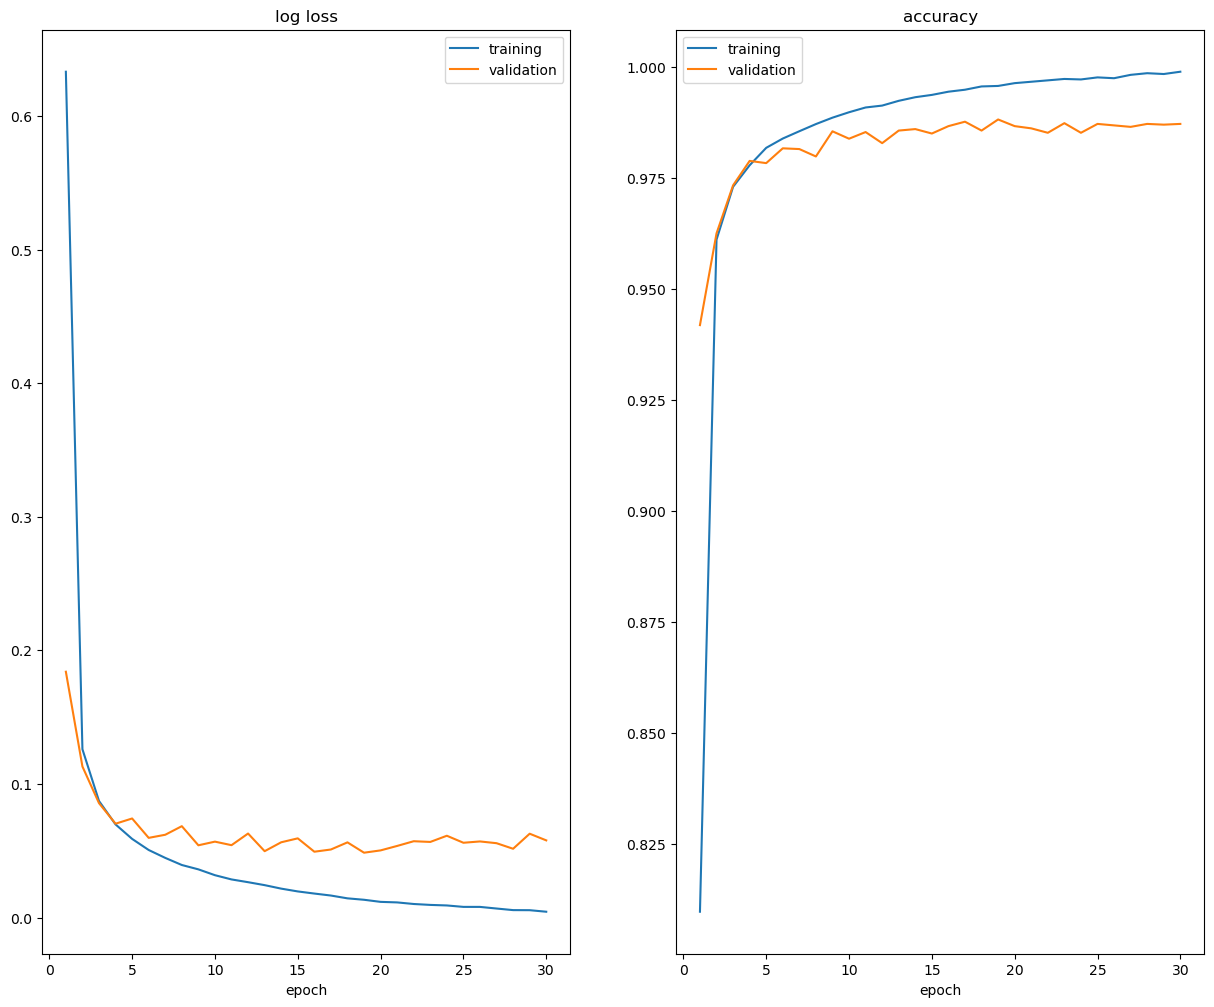

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 12))
axes[0].plot(range(1, n_epochs+1), train_losses, label="training")
axes[0].plot(range(1, n_epochs+1), val_losses, label="validation")
axes[0].set(title="log loss", xlabel="epoch")
axes[0].legend()
axes[1].plot(range(1, n_epochs+1), train_accuracies, label="training")
axes[1].plot(range(1, n_epochs+1), val_accuracies, label="validation")
axes[1].set(title="accuracy", xlabel="epoch")
axes[1].legend();

In [18]:
# Use the validation set to predict labels
ys, y_preds, = evaluate(model, val_loader)
pd.DataFrame({"True": ys, "Predicted": y_preds})

,True,Predicted
0,1,1
1,9,9
2,3,3
3,4,4
4,6,6
...,...,...
5995,4,4
5996,1,1
5997,5,5
5998,0,0


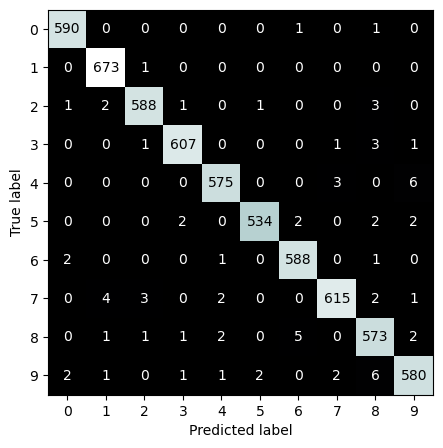

In [19]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(ys, y_preds, ax=ax, colorbar=False, cmap='bone');

เราสามารถทำ hyperparameter tuning เพื่อหาชุดของ hyperparameter ที่ดีที่สุด จากนั้นเราอาจเทรน network ใหม่โดยใช้ทั้ง train และ validation set ก็ได้ (อย่าลืม reload dataset ใหม่อีกครั้ง (`download=True`))

## CNN architectures

<b>Components</b>

<img src="../images/cnn_architecture_components.png" width="900" /><br />

LeNet-5 (1998)
- First CNN
- 2 convolutions + 3 fully connected layers

<img src="../images/lenet5_architecture.png" width="500" /><br />

AlexNet (2012)
- ReLU activations and dropout are introduced

<img src="../images/alexnet_architecture.png" width="650" /><br />

VGG-16 (2014)
- 2x deeper than AlexNet
- More layers (16 or 19 for VGG-19) but smaller filters

<img src="../images/vgg16_architecture.png" width="750" /><br />

Inception-v1 (2014)
- Stack modules containing convolutional layers (rather than stacking convolutional layers)
- Stem and inception modules were named in later versions – "network within a network" concept

<img src="../images/inception_v1_architecture.png" width="900" /><br />

ResNET-50 (2015)
- Popularised skip-connections & batch normalization
- Deep: 152 CNN layers

<img src="../images/resnet_50_architecture.png" width="1000" /><br />

ResNET-50 (2015)
- Popularised skip-connections & batch normalization
- Deep: 152 CNN layers

<img src="../images/resnet_50_architecture.png" width="1000" /><br />

And many others, e.g., Xception (2016), Inception-v4 (2016), ResNEXT-50 (2017)

Network มีขนาดเพิ่มขึ้นเรื่อย ๆ เมื่อเวลาผ่านไป เป็นผลจากความก้าวหน้าของ computational power

`PyTorch` มี pre-trained neural network architecture ให้ใช้มากมาย ส่วนใหญ่ถูก pre-trained โดยใช้ `ImageNet` dataset เราสามารถเข้าถึง pre-trained network เหล่านี้ได้โดยใช้ `torchvision.models` ดูตัวอย่างได้ด้านล่าง

In [20]:
# Load a pre-trained AlexNet model from torchvision.models
# See its source code at https://pytorch.org/vision/stable/_modules/torchvision/models/alexnet.html
alexnet = models.alexnet(pretrained=True).to(device)
print(alexnet)
summary(alexnet, input_size=(3, 300, 300))

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

torch.Size([64, 3, 11, 11])


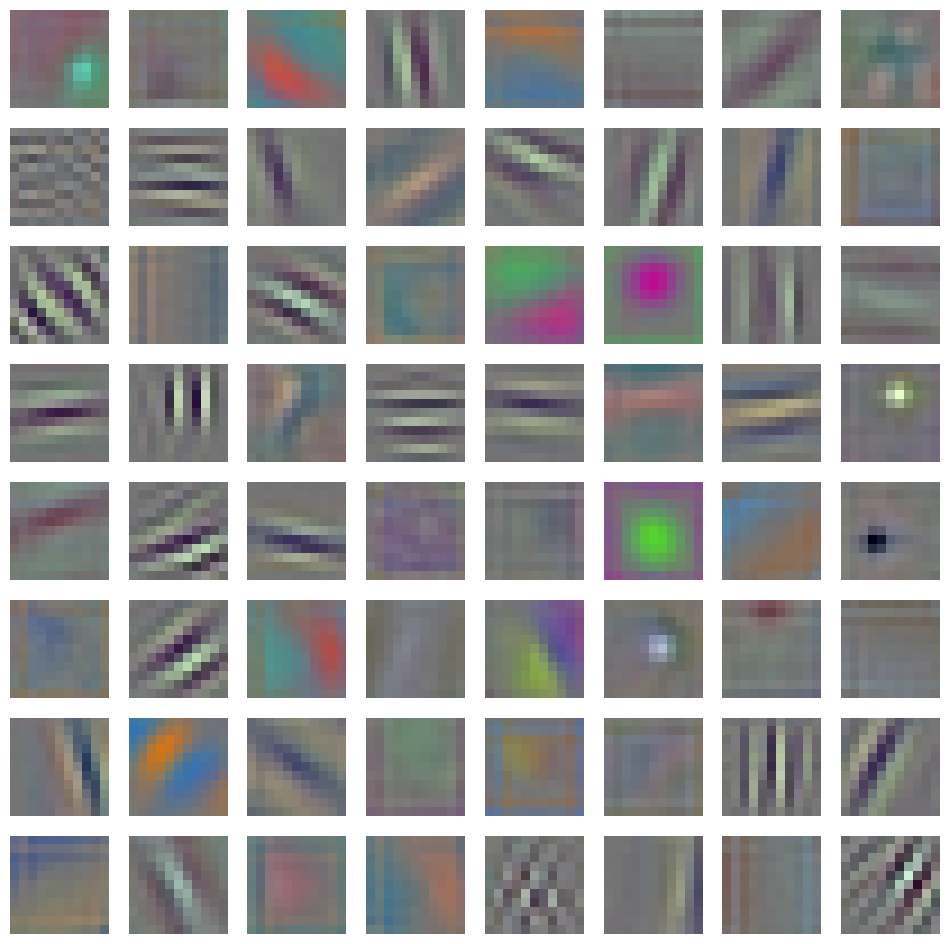

In [21]:
# Obtain the weight kernels of the first convolutional layer
# The information about AlexNet printed above tells us that
# - The first convolutional layer is the first layer of the network (index=0)
# - There are 64 kernels, each of which has 3 channels with a size of 11x11
first_conv_layer = alexnet.features[0]
weights = first_conv_layer.weight.data
print(weights.shape)

# Normalise the kernels for plotting
min_w, max_w = weights.min(), weights.max()
weights -= min_w
weights /= (max_w-min_w)

# Display the kernels
fig, axarr = plt.subplots(8, 8, figsize=(12, 12))
axarr = axarr.flatten()
for ax, kernel in zip(axarr, weights.cpu().numpy()):  # Need to send the weights to the CPU for plotting
                                                      # Plot the three channels at the same time
    ax.imshow(np.swapaxes(kernel, 0, 2))              # RGB
    ax.set_axis_off()

torch.Size([192, 64, 5, 5])


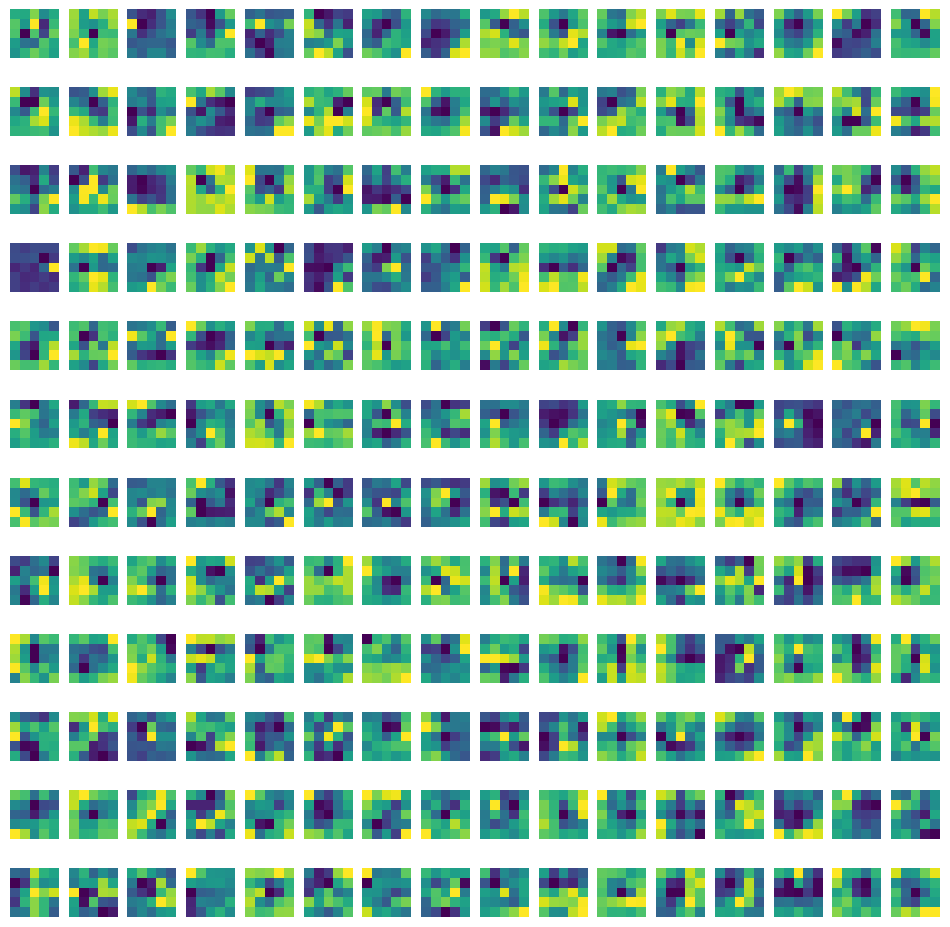

In [22]:
# Obtain the weight kernels of the second convolutional layer
# The information about AlexNet printed above tells us that
# - The second convolutional layer is the fourth layer of the network (index=3)
# - There are 192 kernels, each of which has 64 channels with a size of 5x5
second_conv_layer = alexnet.features[3]
weights = second_conv_layer.weight.data
print(weights.shape)

# Normalise the kernels for plotting
min_w, max_w = weights.min(), weights.max()
weights -= min_w
weights /= (max_w-min_w)

# Display the kernels
fig, axarr = plt.subplots(12, 16, figsize=(12, 12))
axarr = axarr.flatten()
for ax, kernel in zip(axarr, weights[:, 0, :, :].cpu().numpy()):  # Show only the first channel of each kernel
    ax.imshow(kernel)
    ax.set_axis_off()

In [23]:
# Load a pre-trained ResNet-18 model
resnet = models.resnet18(pretrained=True).to(device)
print(resnet)
summary(resnet, input_size=(3, 300, 300))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

torch.Size([64, 3, 7, 7])


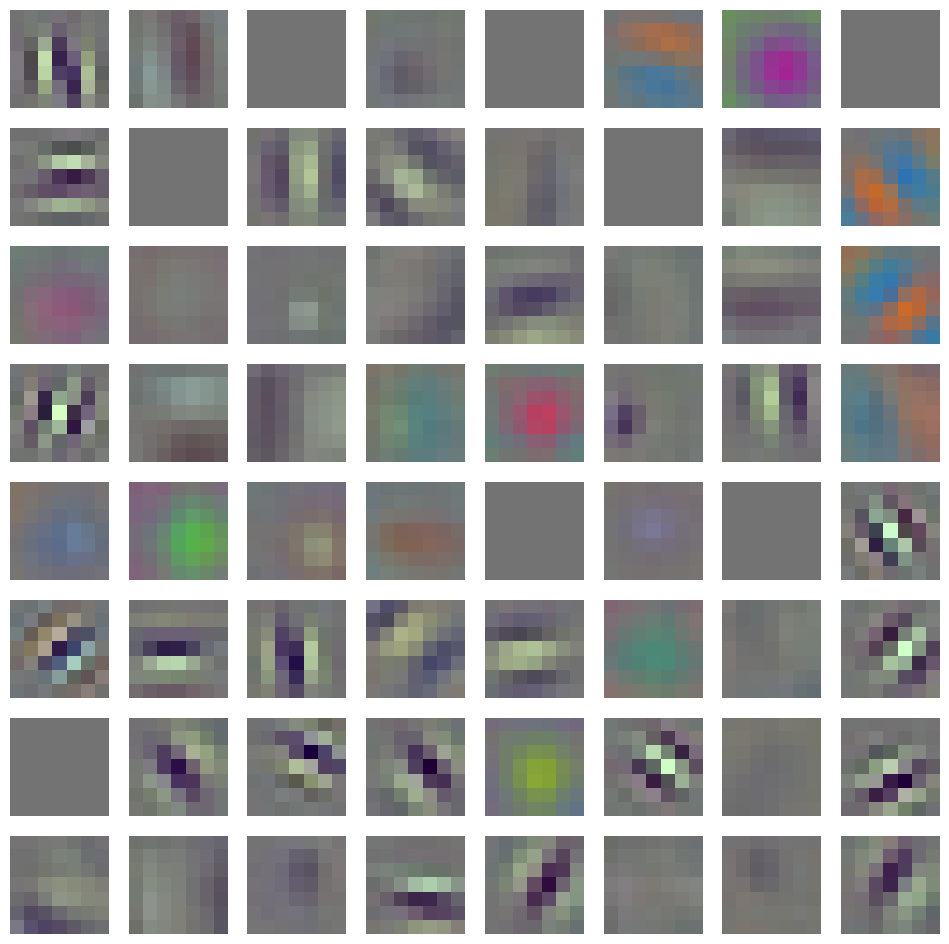

In [24]:
# Obtain the weight kernels of the first convolutional layer
first_conv_layer = resnet.conv1
weights = first_conv_layer.weight.data
print(weights.shape)

# Normalise the kernels for plotting
min_w, max_w = weights.min(), weights.max()
weights -= min_w
weights /= (max_w-min_w)

# Display the kernels
fig, axarr = plt.subplots(8, 8, figsize=(12, 12))
axarr = axarr.flatten()
for ax, kernel in zip(axarr, weights.cpu().numpy()):
    ax.imshow(np.swapaxes(kernel, 0, 2))
    ax.set_axis_off()

## U-nets

จาก CNN architecture แบบที่ผ่าน ๆ มา ข้อมูลในภาพ input ถูกสกัดให้มี dimensionality ลดลง และจบที่การใช้ softmax แปลงเป็น output

แทนที่เราจะจบที่ softmax เราจะเพิ่ม dimensionality แทน (<b>upsampling/upscaling</b>)

U-Net เป็น architecture ที่เป็น conventional autoencoder ชนิดหนึ่ง โดย output ที่ได้จะเป็นภาพ

<img src="../images/unet.png" width="1000" /><br />

## Upsampling

วิธี upsampling ที่นิยม เช่น nearest neighbour, "bed of nails", max unpooling, transposed convolution (up-convolution)

<b>Nearest neighbour</b>

<img src="../images/nearest_neighbour.png" width="250" /><br />

<b>Bed of nails</b>

<img src="../images/bed_of_nails.png" width="250" /><br />

<b>Max unpooling</b>

ใช้เมื่อตำแหน่งในภาพมีความสำคัญ

<img src="../images/max_unpooling.png" width="500" /><br />

<b>Transposed convolution (up-convolution)</b>

Kernel ถูก transposed (หมุน $180^\circ$) ก่อนถูก convoluted

<img src="../images/transposed_conv.png" width="1000" /><br />

จากภาพด้านบน $s$ = stride, $p$ = padding, $k$ = kernel size

เราใช้ $s$, $p$, $k$ คำนวณ $z$ กับ $p'$ โดยที่
- $z$ = จำนวน 0 ที่จะแทรกระหว่าง pixel
- $p'$ = padding ที่ใช้จริงใน transposed convolution

ส่วน $s'$ คือ stride ที่ใช้จริงใน transposed convolution

ภาพที่ได้จาก transposed convolution มักจะมี <a href="https://distill.pub/2016/deconv-checkerboard/">checkerboard artifact</a>

ตัวอย่าง transposed convolution แสดงดังภาพด้านล่าง

<img src="../images/transposed_conv_ex1.png" width="900" /><br />

<img src="../images/transposed_conv_ex2.png" width="500" /><br />

In [25]:
# Download the ChestMNIST dataset โดยใช้คำสั่งต่อไปนี้ (ต้องติดตั้ง wget ก่อน (pip install wget))
# !python -m wget https://zenodo.org/record/6496656/files/chestmnist.npz
# !move chestmnist.npz ../data

In [26]:
# Import data (assuming it has been downloaded)
data_path = "../data/chestmnist.npz"
data = np.load(data_path)
print(data.files)

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


เราต้องการปิดบาง pixel ของทุกภาพใน dataset เพื่อใช้เป็น input สำหรับ U-net ในการกู้ภาพคืน

In [27]:
class ChestMNIST(Dataset):
    """
    Class for masking the images of the ChestMNIST dataset.
    
    Parameters
    ----------
    data_path : str
    
        The path to the data.
        
    p : float
    
        A probability for a random mask.
        
    split : str
    
        A split argument to dictate what part of the data to load ("train", "validation", "test").
        
    transform: torchvision.transforms
    
        A transform to be applied to the data.
    
    """
    def __init__(self, data_path, p=0.5, transform=None, split="train"):
        self.data_path = data_path
        self.p = p
        self.transform = transform

        split_dict = {"train": "train_images", "validation": "val_images", "test": "test_images"}
        if split in split_dict:
            self.data = np.load(data_path)[split_dict[split]]
        else:
            raise ValueError("split parameter must be 'train', 'validation', or 'test'")

        # Transform to Tensor and add channel dimension
        self.data = torch.from_numpy(self.data).unsqueeze(1)

    def _get_mask(self, img_shape):
        """
        Generates a binary mask of the size of the sample to
        randomly erasesome data points based on the probability p.
        
        """
        c, w, h = img_shape
        masked_points = int((1 - self.p) * w * h)
        masked_idx = torch.randint(0, w * h, (masked_points,))
        mask = torch.ones((w * h))
        mask[masked_idx] = 0
        mask = mask.view(1, w, h)
        mask.repeat(c, 1, 1)
        return mask

    def __getitem__(self, idx):
        sample = self.data[idx]

        # Apply transforms
        if self.transform:
            sample = self.transform(sample)

        # Mask data
        mask = self._get_mask(sample.shape)
        masked_sample = sample * mask

        return masked_sample, sample

    def __len__(self):
        return len(self.data)

In [28]:
# Instantiate the class for a training set and a validation set
train_dataset = ChestMNIST(data_path, split="train")
val_dataset = ChestMNIST(data_path, split="validation")

In [29]:
# Instantiate a U-net
set_seed(42)
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(8, 8, 8),
    strides=(1, 1),
    act="mish"
).to(device)
summ = summary(
    model,
    input_size=(1, 28, 28)  # Inputs are grayscale (1 channel) images with a size of 28x28
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
    InstanceNorm2d-2            [-1, 8, 28, 28]               0
           Dropout-3            [-1, 8, 28, 28]               0
              Mish-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             584
    InstanceNorm2d-6            [-1, 8, 28, 28]               0
           Dropout-7            [-1, 8, 28, 28]               0
              Mish-8            [-1, 8, 28, 28]               0
            Conv2d-9            [-1, 8, 28, 28]             584
   InstanceNorm2d-10            [-1, 8, 28, 28]               0
          Dropout-11            [-1, 8, 28, 28]               0
             Mish-12            [-1, 8, 28, 28]               0
   SkipConnection-13           [-1, 16, 28, 28]               0
  ConvTranspose2d-14            [-1, 8,

In [30]:
# Hyperparameters
set_seed(42)
p = 0.6
lr = 1e-2
batch_size = 128
num_workers = 0
wd = 1e-6
n_epochs = 20
optimiser = torch.optim.Adam(params=model.parameters(), lr=lr, weight_decay=wd)
mseloss = nn.MSELoss()

In [31]:
# Dataset and dataloader
transform = Compose([Lambda(lambda x: x/255.)])
train_dataset = ChestMNIST(data_path, split="train", p=p, transform=transform)
val_dataset = ChestMNIST(data_path, split="validation", p=p, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [32]:
def train2(model, optimizer, criterion, data_loader):
    model.train()
    train_loss = 0.
    for inp, target in data_loader:
        inp, target = inp.to(device), target.to(device)
        optimizer.zero_grad()
        outp = model(inp)
        loss = criterion(outp, target)
        loss.backward()
        train_loss += loss*inp.size(0)
        optimizer.step()
    avg_train_loss = train_loss / len(data_loader.dataset)
    return avg_train_loss

def validate2(model, criterion, data_loader):
    model.eval()
    val_loss = 0.
    with torch.no_grad():
        for inp, target in data_loader:
            inp, target = inp.to(device), target.to(device)
            outp = model(inp)
            loss = criterion(outp, target)
            val_loss += loss*inp.size(0)
        avg_val_loss = val_loss / len(data_loader.dataset)
        return avg_val_loss

In [33]:
# Compute log loss of the model and plot it over epoches
# You can use the "livelossplot" module to plot a real-time evolution of loss
train_losses, val_losses = [], []
for epoch in range(n_epochs):
    train_loss = train2(model, optimiser, mseloss, train_loader)
    train_losses.append(train_loss.item())
    val_loss = validate2(model, mseloss, val_loader)
    val_losses.append(val_loss.item())

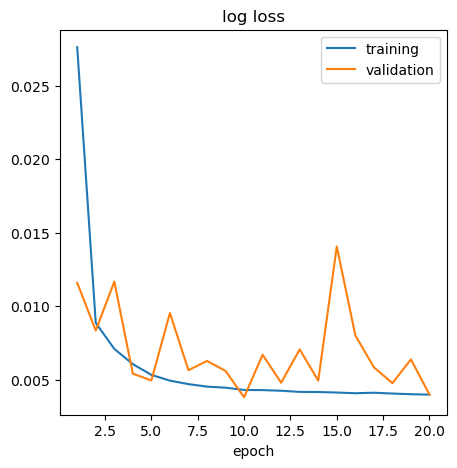

In [34]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(range(1, n_epochs+1), train_losses, label="training")
ax.plot(range(1, n_epochs+1), val_losses, label="validation")
ax.set(title="log loss", xlabel="epoch")
ax.legend();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


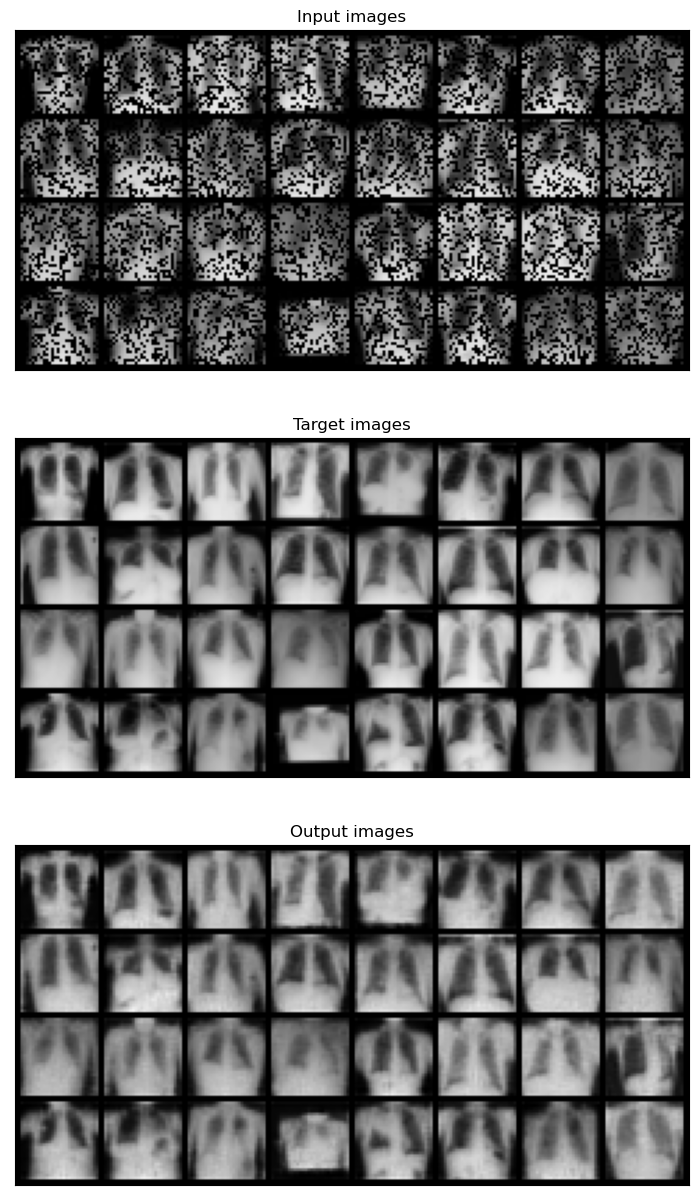

In [35]:
# Visualise 32 input, reconstructed and target samples from a validation batch
inputs, targets = next(iter(val_loader))
inputs, targets = inputs[:32], targets[:32]
outputs = model(inputs.to(device))

input_grid = make_grid(inputs)
output_grid = make_grid(outputs)
target_grid = make_grid(targets)

fig, axes = plt.subplots(3, 1, figsize=(25, 15))
axes[0].imshow(input_grid.detach().cpu().permute(1, 2, 0))
axes[0].set(title="Input images", xticks=[], yticks=[])
axes[1].imshow(target_grid.detach().cpu().permute(1, 2, 0))
axes[1].set(title="Target images", xticks=[], yticks=[])
axes[2].imshow(output_grid.detach().cpu().permute(1, 2, 0))
axes[2].set(title="Output images", xticks=[], yticks=[]);

## Receptive field

Receptive field คือบริเวณในภาพ input ที่มีผลต่อ output

Receptive field จะกำหนดค่า hyperparameter (filter size, stride, จำนวน convolutional layer) ที่เราควรใช้เพื่อรองรับ receptive field ทั้งหมด

<img src="../images/receptive_field.png" width="500" /><br />